# $I_{local}$ for 1D tuning 

author: laquitainesteeve@gmail.com from code by Matthew Chalk


**Description**: 20 neuron direction-tuned encoder | Poisson noise

## Setup 

Setup `fisher_info_limits2'

In [233]:
# import packages
import os
import numpy as np
from numpy import log, zeros, exp, sqrt, pi, arctan2, sin, cos, linspace, mean
from numpy.random import rand, randn, poisson
import matplotlib.pyplot as plt
from scipy.special import gammaln
from tqdm import tqdm

# setup project path
proj_path = '/home/steeve/steeve/idv/code/fisher-info-limits'
os.chdir(proj_path)

# setup pipeline parameters
SEED = 0
NXPLOT = 50
dx = 0.005            # smaller dx = slower but more accurate

# setup tuning curve parameters
n_neurons = 20          # number of neurons
tc_pms = {
    "width": 0.29,      # tuning curve width
    "baseline": 0.01,   # baseline firing rate
    "amplitude": 19,    # average firing rate amplitude
}

## Functions

In [225]:
# utils -----------------------------

def sum2(data: np.array, axis=1): 
    """sum over columns (axis 1)
    while keeping data dimensionality

    Args:
        data (_type_): _description_
        axis (int, optional): _description_. Defaults to 1.

    Returns:
        _type_: _description_
    """
    return data.sum(axis, keepdims=True)


def wrap_to_pi(dirs: np.array):
    """wrap circularly

    Args:
        dirs (np.array): directions in radians

    Returns:
        np.array: directions wrapped circularly
    """
    return ((dirs + pi) % (2 * pi) - pi).flatten()


def logsumexp(a: np.array, axis=0):
    """
    Computes log(sum(exp(a), axis)) while avoiding numerical underflow.
    Equivalent to MATLAB's logsumexp by Tom Minka.

    Parameters
    ----------
    a : np.ndarray
        Input array.
    axis : int, optional
        Axis along which to sum. Default is 0.

    Returns
    -------
    s : np.ndarray
        Log-sum-exp of the input along the specified axis.
    """
    # find the maximum along the specified axis (for numerical stability)
    a_max = np.max(a, axis=axis, keepdims=True)

    # subtract and exponentiate
    a_stable = a - a_max
    s = a_max + log(np.sum(np.exp(a_stable), axis=axis, keepdims=True))

    # remove the extra dimension
    s = np.squeeze(s, axis=axis)
    a_max = np.squeeze(a_max, axis=axis)

    # handle non-finite max values (like -inf)
    return np.where(np.isfinite(a_max), s, a_max)


#  Neural encoder ----------------------------

def tuning_curve(x: np.array, pref_dirs: np.array, amplitude=19, width=0.29, baseline=0.01):
    """Von-mises like tuning function
    
    Args:
        x (np.array): scalar or array of angles of shape (1, N)
        pref_dirs: 

    Returns: 
        array of shape (n_neurons, len(x)) firing rates
    """ 
    # enforce array
    x = np.atleast_1d(x).flatten()
    
    # compute
    tc = amplitude * np.exp((np.cos(x[None,:] - pref_dirs[:,None]) - 1) / width) + baseline
    tc = tc.squeeze() # remove useless first dimension
    
    # enforce 2d with shape (n_neurons, N)
    if tc.ndim == 1: 
        tc = np.atleast_2d(tc).T
    return tc


def tuning_curve_grad(x: np.array, pref_dirs: np.array, amplitude=19, width=0.29, baseline=0.01):
    """
    Gradient of the tuning curve.
    
    Parameters
    ----------
    x : array_like
        Input angles (radians)
    pref_dirs : array_like
        Preferred directions of neurons
    tuning_curve : callable or array_like
        Either a function tuning_curve(x) or precomputed array of same shape as x - pref_dirs
    width : float
        Tuning curve width parameter
    """
    return -np.sin(x - pref_dirs[:, None]) * tuning_curve(x, pref_dirs, amplitude, width, baseline) / width


# Information metrics ----------------------------

def compute_I_brute_force(x: np.array, xplot: np.array, tc_pms: dict, dx=0.005, nsamp:int=10000):
    """Compute mutual information (I(R;X)) in a 
    brute force manner

    Args:
        x
        xplot
        dx
        nsamp
        tc_pms
    
    Returns:

    """    
    # number of directions to plot
    nxplot = len(xplot)

    # initialize ssi and mean squared error
    ssi = zeros((1, nxplot))
    mse = zeros((1, nxplot))

    # entropy of x
    Hx = log(2*pi)

    # tuning curves
    x_rates = tuning_curve(x, **tc_pms)

    # compute I(X;r)
    for i in tqdm(range(nsamp),'I brute force'):

        # get neural response to directions as spike counts
        r = poisson( tuning_curve(xplot, **tc_pms) )

        # estimate log p(rsamp)
        logprx =  log(x_rates.T) @ r - sum2(x_rates.T) - sum(gammaln(r+1)) - log(2*pi)
        logpr = logsumexp(logprx + log(dx), 0)
        logpx_r = logprx - logpr

        # entropy of X|r of shape (1, len(xplot))
        HX_r = (-sum(exp(logpx_r) * logpx_r, 1) * dx)[None]

        # running average of SSI
        ssi = ssi*(i)/(i+1) + (Hx-HX_r)/(i+1)

        # mean square error
        xtemp = wrap_to_pi(x + 2*pi*rand())
        xtemp_rates = tuning_curve(xtemp, **tc_pms)
        logprx = log(xtemp_rates.T) @ r - sum2(xtemp_rates.T) - sum(gammaln(r+1)) - log(2*pi)
        logpr = logsumexp(logprx + log(dx), 0)
        logpx_r = logprx - logpr

        # of shape (1, len(xplot))
        xhat = (arctan2(sin(xtemp) @ exp(logpx_r) * dx, cos(xtemp) @ exp(logpx_r) * dx))[None]
        
        # of shape (1, len(xplot))
        circular_error = wrap_to_pi(xhat - xplot)**2
        
        # of shape (1, len(xplot))
        mse = mse*(i)/(i+1) + circular_error/(i+1)
    return ssi, mse


def compute_circular_ilocal(x: np.array, xplot: np.array, tc_pms: dict, dx=0.005, nsamp=10000):
    """Compute circular ilocal

    Args:
        x: circular space in radian
        xplot: x points to plot        
        tc_pms (dict): tuning curve parameters
    
    Returns:
        
    """
    
    # limits of gamma to sample. Smaller gamma_min more accurate only if dx is
    # very small (so slower). 
    gamma_min = 0.1
    gamma_max = 50
    nxplot = len(xplot) # number of x points to plot

    # initialise I_local(x) = mean( I_i(x) ), where mean is over samples
    Ilocal = zeros((1, nxplot))

    # Initialise mean( I_i(x).^2 ), where mean is over samples, useful for err bars
    Ilocal2 = zeros((1, nxplot))

    # Fisher information
    fisher_info = (tuning_curve_grad(xplot, **tc_pms).T**2./tuning_curve(xplot, **tc_pms).T).sum(1)

    # compute integral between gamma=0 and gamma=gamma_min analytically
    I0 = log(1 + gamma_min * fisher_info) / 2

    # average neural response to x
    x_rates = tuning_curve(x, **tc_pms)

    # index for wrapped gaussian
    k = np.arange(-20,21).reshape(1,1,-1)

    for i in tqdm(range(nsamp), "Ilocal"):

        # sample gamma from p(gamma)~1/gamma, between gamma_min and gamma_mas
        gamma = exp( rand() * (log(gamma_max) - log(gamma_min)) + log(gamma_min))

        # sample y~p(y|x), of shape (len(x), )
        y = wrap_to_pi(xplot + sqrt(gamma).T * randn(1,nxplot))

        # sample r~p(r|y), of shape (n_neurons, len(x))
        r = poisson( tuning_curve(wrap_to_pi(y + sqrt(gamma).T * randn(1,nxplot)), **tc_pms) )

        # compute log p(r|x)
        logpr_x =  log(x_rates.T) @ r - sum2(x_rates.T) - sum(gammaln(r+1))

        # compute d p(y|x)/dy, where p(y|x) is wrapped gaussian, of shape (len(x), nxplot)
        dphi = (((x.T-y)[:,:,None] + 2*pi*k) / gamma * exp(-0.5*((x.T-y)[:,:,None] + 2*pi*k)**2 / gamma ) / sqrt(2*pi*gamma)).sum(2)

        # compute d p(r|y)/dy, of shape (nxplot,)
        dpr_y = sum(exp(logpr_x) * dphi, 0) * dx

        # compute log p(y|x), where p(y|x) is wrapped gaussian
        logphi = logsumexp(-0.5*((x.T-y)[:,:,None] + 2*pi*k)**2 / gamma - 0.5*log(2*pi*gamma),2)

        # compute p(r|y)
        logpr_y = logsumexp(logphi + logpr_x + log(dx), 0)

        # combine, to compute dlogp(r|y) = dp(r|y)/p(r|y)
        dlogpr_y = dpr_y  / exp(logpr_y)

        # update for Ilocal
        dIlocal = 0.5 * log(gamma_max / gamma_min) * gamma * dlogpr_y**2 + I0

        # update Ilocal
        Ilocal = Ilocal*(i)/(i+1) + dIlocal/(i+1)

        # update term for error
        Ilocal2 = Ilocal2*(i)/(i+1) + dIlocal**2/(i+1)

    # compute information metrics
    Ilocal_err = sqrt(Ilocal2 - Ilocal**2) / sqrt(nsamp)
    Inf_aprx = np.mean(Ilocal)
    Inf_err = sqrt(np.mean(Ilocal_err**2))
    std_err = sqrt(Ilocal2 - Ilocal**2)/sqrt(nsamp)
    return Ilocal, Inf_aprx, Inf_err, std_err, fisher_info, x_rates

## Neural encoder

Text(0.5, 1.0, 'Neural Tuning Curves')

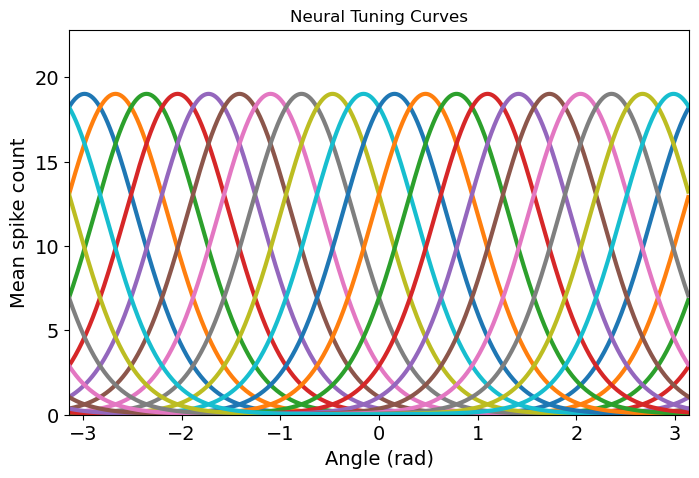

In [228]:
# x points to plot, from -pi to pi
xplot = np.linspace(-pi, pi, NXPLOT + 1)
xplot = xplot[:-1]                              # OK!

# x used to compute probability distributions 
# of shape (1, N)
x = np.arange(-pi, pi, dx)
x = x[:-1][None]                                # OK!

# position centers of tuning curves, uniformly spaced
pref_dirs = np.linspace(-pi, pi, n_neurons + 1)[:-1]
pref_dirs = pref_dirs - np.mean(pref_dirs)

# plot tuning curves
plt.figure(figsize=(8, 5))
plt.plot(x.flatten(), tuning_curve(x, pref_dirs, **tc_pms).T, linewidth=3)
plt.ylabel('Mean spike count', fontsize=14)
plt.xlabel('Angle (rad)', fontsize=14)
plt.xlim([-pi, pi])
plt.ylim([0, tc_pms['baseline'] + 1.2*tc_pms['amplitude']])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Neural Tuning Curves')

# I(R;X) 
- Execution time: 20 secs

In [ ]:
%%time

# 20 neurons with high firing rates
n_neurons = 20
pref_dirs = linspace(-pi, pi, n_neurons + 1)[:-1] - mean(pref_dirs)
tc_pms = {"width": 0.29, "baseline": 0.01, "amplitude": 19, "pref_dirs": pref_dirs}
ssi_n20_high, mse_n20_high = compute_I_brute_force(x, xplot, tc_pms, dx=0.005, nsamp=10000)

# 4 neurons with high firing rates
n_neurons = 4
pref_dirs = linspace(-pi, pi, n_neurons + 1)[:-1] - mean(pref_dirs)
tc_pms = {"width": 0.29, "baseline": 0.01, "amplitude": 19, "pref_dirs": pref_dirs}
ssi_n4_high, mse_n4_high = compute_I_brute_force(x, xplot, tc_pms, dx=0.005, nsamp=10000)

# 4 neurons with high firing rates
n_neurons = 4
pref_dirs = linspace(-pi, pi, n_neurons + 1)[:-1] - mean(pref_dirs)
tc_pms = {"width": 0.29, "baseline": 0.01, "amplitude": 3, "pref_dirs": pref_dirs}
ssi_n4_low, mse_n4_low = compute_I_brute_force(x, xplot, tc_pms, dx=0.005, nsamp=10000)

I brute force:   0%|          | 0/10000 [00:00<?, ?it/s]

I brute force: 100%|██████████| 10000/10000 [00:15<00:00, 654.27it/s]

CPU times: user 1min 46s, sys: 47.7 ms, total: 1min 46s
Wall time: 49.5 s


## Compute $I_{local}$

- Execution time: 24 min

In [234]:
%%time

# 20 neurons with high firing rate
n_neurons = 20
pref_dirs = linspace(-pi,pi,n_neurons+1)[:-1] - mean(pref_dirs)
tc_pms = {"width": 0.29, "baseline": 0.01, "amplitude": 19, "pref_dirs": pref_dirs}
Ilocal_n20_high, _, _, _, fisher_info_n20_high, x_rates_n20_high = compute_circular_ilocal(x, xplot, tc_pms, dx=0.005, nsamp=10000)

# 4 neurons with high firing rate
n_neurons = 4
pref_dirs = linspace(-pi,pi,n_neurons+1)[:-1] - mean(pref_dirs)
tc_pms = {"width": 0.29, "baseline": 0.01, "amplitude": 19, "pref_dirs": pref_dirs}
Ilocal_n4_high, _, _, _, fisher_info_n4_high, x_rates_n4_high = compute_circular_ilocal(x, xplot, tc_pms, dx=0.005, nsamp=10000)

# 4 neurons with low firing rate
n_neurons = 4
pref_dirs = linspace(-pi,pi,n_neurons+1)[:-1] - mean(pref_dirs)
tc_pms = {"width": 0.29, "baseline": 0.01, "amplitude": 3, "pref_dirs": pref_dirs}
Ilocal_n4_low, _, _, _, fisher_info_n4_low, x_rates_n4_low = compute_circular_ilocal(x, xplot, tc_pms, dx=0.005, nsamp=10000)

Ilocal: 100%|██████████| 10000/10000 [08:22<00:00, 19.89it/s]

CPU times: user 46min 53s, sys: 3min 33s, total: 50min 27s
Wall time: 25min 7s


## Plot

/tmp/ipykernel_2782020/1011017534.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(handlelength = 0, labelcolor = 'linecolor', **legend)
/tmp/ipykernel_2782020/1011017534.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(handlelength = 0, labelcolor = 'linecolor', **legend)
/tmp/ipykernel_2782020/1011017534.py:117: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(handlelength = 0, labelcolor = 'linecolor', **legend)


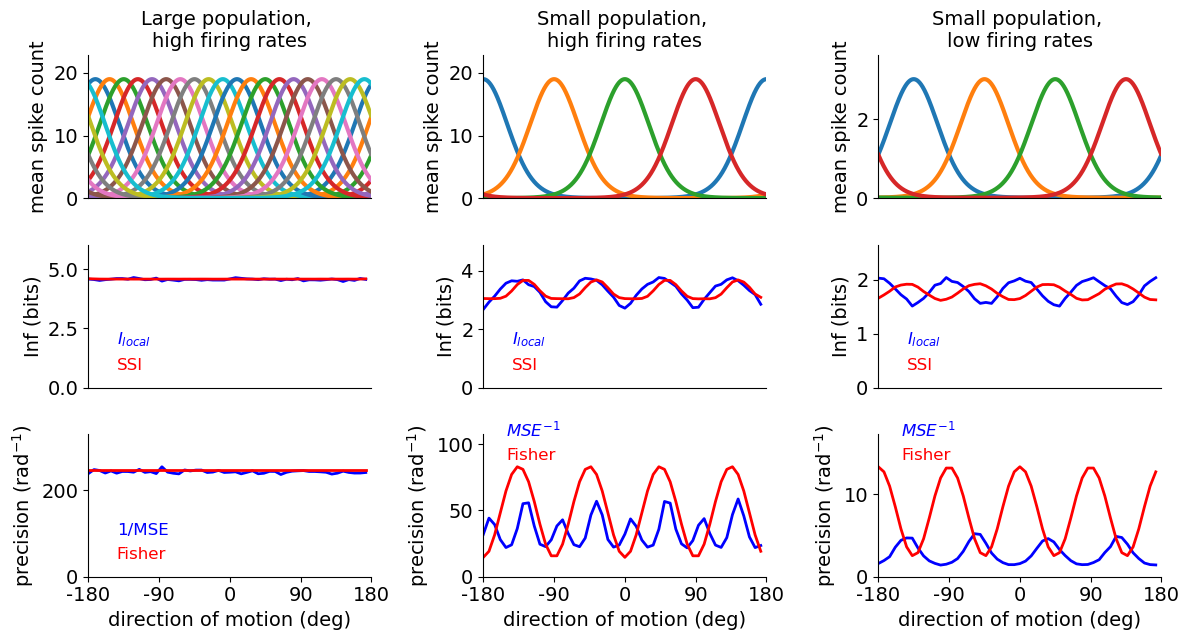

In [260]:
# setup params
legend = {'frameon': False, 'fontsize': 12}

# setup figure
fig, axes = plt.subplots(3,3, figsize=(12, 6.5))

# 20 neurons -------------------------------------------------------

# Mean spike count 
ax = axes[0,0]
ax.plot(x.flatten(), x_rates_n20_high.T, linewidth=3)
# formatting
ax.set_ylabel('mean spike count', fontsize=14)
ax.set_xlim([-np.pi, np.pi])
ax.set_ylim([0, 1.2 * np.max(x_rates_n20_high)])
ax.tick_params(labelsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.legend(handlelength = 0, labelcolor = 'linecolor', **legend)
ax.set_title('Large population, \nhigh firing rates', fontsize=14)

# Information 
ax = axes[1,0]
ax.plot(xplot.flatten(), Ilocal_n20_high.flatten()/np.log(2), 'b', linewidth=2, label='$I_{local}$')
ax.plot(xplot.flatten(), ssi_n20_high.flatten()/np.log(2), 'r-', linewidth=2, label='SSI')
# formatting
ax.set_ylabel('Inf (bits)', fontsize=14)
ax.set_ylim([0, 1.3 * np.max(Ilocal_n20_high)/np.log(2)])
ax.set_xlim([-np.pi, np.pi])
ax.tick_params(labelsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.legend(handlelength = 0, labelcolor = 'linecolor', **legend)

# Precision 
ax = axes[2,0]
ax.plot(xplot.flatten(), 1/(mse_n20_high.flatten() + np.finfo(float).eps), 'b-', linewidth=2, label='1/MSE')
ax.plot(xplot.flatten(), fisher_info_n20_high, 'r-', linewidth=2, label='Fisher')
# formatting
ax.set_ylabel('precision (rad$^{-1}$)', fontsize=14)
ax.set_ylim([0, 1.3 * np.max([np.max(fisher_info_n20_high), np.max(1./(mse_n20_high + np.finfo(float).eps))])])
ax.set_xlim([-np.pi, np.pi])
ax.tick_params(labelsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xtick_positions = np.linspace(-np.pi, np.pi, 5)
xtick_labels = np.linspace(-np.pi, np.pi, 5) * 180 / np.pi
ax.set_xticks(xtick_positions)
ax.set_xticklabels([f'{label:.0f}' for label in xtick_labels])
ax.legend(handlelength = 0, labelcolor = 'linecolor', **legend)
ax.set_xlabel('direction of motion (deg)', fontsize=14)


# 4 neurons with high firing rate -------------------------------------------------------

# Mean spike count 
ax = axes[0,1]
ax.plot(x.flatten(), x_rates_n4_high.T, linewidth=3)
# formatting
ax.set_ylabel('mean spike count', fontsize=14)
ax.set_xlim([-np.pi, np.pi])
ax.set_ylim([0, 1.2 * np.max(x_rates_n4_high)])
ax.tick_params(labelsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.legend(handlelength = 0, labelcolor = 'linecolor', **legend)
ax.set_title('Small population, \nhigh firing rates', fontsize=14)

# Information
ax = axes[1,1]
ax.plot(xplot.flatten(), Ilocal_n4_high.flatten()/np.log(2), 'b', linewidth=2, label='$I_{local}$')
ax.plot(xplot.flatten(), ssi_n4_high.flatten()/np.log(2), 'r-', linewidth=2, label='SSI')
# formatting
ax.set_ylabel('Inf (bits)', fontsize=14)
ax.set_ylim([0, 1.3 * np.max(Ilocal_n4_high)/np.log(2)])
ax.set_xlim([-np.pi, np.pi])
ax.tick_params(labelsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.legend(handlelength = 0, labelcolor = 'linecolor', **legend)

# Precision
ax = axes[2,1]
ax.plot(xplot.flatten(), 1/(mse_n4_high.flatten() + np.finfo(float).eps), 'b-', linewidth=2, label='$MSE^{-1}$')
ax.plot(xplot.flatten(), fisher_info_n4_high, 'r-', linewidth=2, label='Fisher')
# formatting
ax.set_ylabel('precision (rad$^{-1}$)', fontsize=14)
ax.set_ylim([0, 1.3 * np.max([np.max(fisher_info_n4_high), np.max(1./(mse_n4_high + np.finfo(float).eps))])])
ax.set_xlim([-np.pi, np.pi])
ax.tick_params(labelsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xtick_positions = np.linspace(-np.pi, np.pi, 5)
xtick_labels = np.linspace(-np.pi, np.pi, 5) * 180 / np.pi
ax.set_xticks(xtick_positions)
ax.set_xticklabels([f'{label:.0f}' for label in xtick_labels])
ax.legend(handlelength = 0, labelcolor = 'linecolor', **legend, loc=(0.01, 0.75))
ax.set_xlabel('direction of motion (deg)', fontsize=14)

# 4 neurons with low firing rate -------------------------------------------------------

# Mean spike count 
ax = axes[0,2]
ax.plot(x.flatten(), x_rates_n4_low.T, linewidth=3)
# formatting
ax.set_ylabel('mean spike count', fontsize=14)
ax.set_xlim([-np.pi, np.pi])
ax.set_ylim([0, 1.2 * np.max(x_rates_n4_low)])
ax.tick_params(labelsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.legend(handlelength = 0, labelcolor = 'linecolor', **legend)
ax.set_title('Small population, \nlow firing rates', fontsize=14)

# Information
ax = axes[1,2]
ax.plot(xplot.flatten(), Ilocal_n4_low.flatten()/np.log(2), 'b', linewidth=2, label='$I_{local}$')
ax.plot(xplot.flatten(), ssi_n4_low.flatten()/np.log(2), 'r-', linewidth=2, label='SSI')
ax.legend(**legend)

# formatting
ax.set_ylabel('Inf (bits)', fontsize=14)
ax.set_ylim([0, 1.3 * np.max(Ilocal_n4_low)/np.log(2)])
ax.set_xlim([-np.pi, np.pi])
ax.tick_params(labelsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.legend(handlelength = 0, labelcolor = 'linecolor', **legend)

# Precision
ax = axes[2,2]
ax.plot(xplot.flatten(), 1/(mse_n4_low.flatten() + np.finfo(float).eps), 'b-', linewidth=2, label='$MSE^{-1}$')
ax.plot(xplot.flatten(), fisher_info_n4_low, 'r-', linewidth=2, label='Fisher')
# formatting
ax.set_ylabel('precision (rad$^{-1}$)', fontsize=14)
ax.set_ylim([0, 1.3 * np.max([np.max(fisher_info_n4_low), np.max(1./(mse_n4_low + np.finfo(float).eps))])])
ax.set_xlim([-np.pi, np.pi])
ax.tick_params(labelsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xtick_positions = np.linspace(-np.pi, np.pi, 5)
xtick_labels = np.linspace(-np.pi, np.pi, 5) * 180 / np.pi
ax.set_xticks(xtick_positions)
ax.set_xticklabels([f'{label:.0f}' for label in xtick_labels])
ax.legend(handlelength = 0, labelcolor = 'linecolor', **legend, loc=(0.01, 0.75))
ax.set_xlabel('direction of motion (deg)', fontsize=14)

# formatting
plt.tight_layout()

# save figure
plt.savefig('figures/fig1_v2.svg', dpi=300, bbox_inches='tight', transparent=True)
plt.savefig('figures/fig1_v2.pdf', dpi=300, bbox_inches='tight', transparent=True)